In [1]:
import os
import sys
import shutil
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import cv2
import importlib
import dbops_updated as dbops

from facelib import FaceRecognizer, FaceDetector
from facelib import get_config, add_from_folder, load_facebank, update_facebank

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import display
from PIL import Image  # For loading images

import glob


In [2]:
importlib.reload(dbops)  # Reload the module from source

<module 'dbops_updated' from '/home/u1541638/Projects/Data-Mining-Spring-2025-Project/dbops_updated.py'>

In [3]:
TEST_MOVIE = "tt0075314"
CLUSTER_DIR = "/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output"

In [4]:
movie_ref = dbops.Movie(TEST_MOVIE)
title = movie_ref.get_title()
cluster_dir_movie = os.path.join(CLUSTER_DIR, title)
print(f"Movie title: {title}")
print(f"Cluster directory: {cluster_dir_movie}")

Movie title: Taxi Driver
Cluster directory: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver


In [33]:
clusters = {}
for p in glob.glob(cluster_dir_movie + "/*"):
    cluster_name = p.split("/")[-1]
    num_files = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    print(f"Cluster: {cluster_name}, Number of files: {num_files}")
    if num_files > 0:
        clusters[(p.split("/")[-1])] = p

print(f"Clusters found: {clusters}")

Cluster: tt0075314_cluster_0, Number of files: 10
Cluster: tt0075314_cluster_7, Number of files: 7
Cluster: tt0075314_cluster_9, Number of files: 10
Cluster: tt0075314_cluster_10, Number of files: 4
Cluster: tt0075314_cluster_4, Number of files: 10
Cluster: tt0075314_cluster_6, Number of files: 8
Cluster: tt0075314_cluster_1, Number of files: 9
Cluster: tt0075314_cluster_5, Number of files: 8
Cluster: tt0075314_cluster_11, Number of files: 7
Cluster: tt0075314_cluster_2, Number of files: 10
Cluster: tt0075314_cluster_8, Number of files: 7
Clusters found: {'tt0075314_cluster_0': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_0', 'tt0075314_cluster_7': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_7', 'tt0075314_cluster_9': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_9', 'tt0075314_cluster_10': '/scratch/u1541638/Data-

In [34]:
from pathlib import Path

def add_from_folder(folder_path='./', person_name='unknow'):
    
    print('only a face in each image and all image from the same person')
    dir_path = Path(folder_path)
    if not dir_path.is_dir():
        exit('dir does not exists !!')

    # create facebank folder if is not exists
    save_path = Path(os.path.dirname(os.path.realpath('/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models')), 'models/data/facebank')
    print(save_path)
    if not save_path.exists():
        save_path.mkdir()


    save_path = Path(f'{save_path}/{person_name}')
    if not save_path.exists():
        save_path.mkdir()
    print('loading ...')
    # init detector
    detector = FaceDetector(name='resnet')

    counter = 0
    for img_path in dir_path.iterdir():
        img = cv2.imread(str(img_path))
        if img is None:
            raise Exception('this image has a problem: ', img_path)
        face = detector.detect_align(img)[0].cpu().numpy()
        if len(face.shape) > 1:
            save_name = f'{save_path}/{dir_path.name}_{counter}.jpg'
            cv2.imwrite(save_name, face[0])
            counter += 1
        else:
            print(img_path, 'in this image did not detect any face')
    print('images saved in this path: ', save_path)  
            


In [35]:
for cluster_name, cluster_path in clusters.items():
    print(f"Cluster name: {cluster_name}")
    print(f"Cluster path: {cluster_path}")
    add_from_folder(cluster_path, cluster_name)


Cluster name: tt0075314_cluster_0
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_0
only a face in each image and all image from the same person
/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank
loading ...
images saved in this path:  /home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank/tt0075314_cluster_0
Cluster name: tt0075314_cluster_7
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_7
only a face in each image and all image from the same person
/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank
loading ...
images saved in this path:  /home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank/tt0075314_cluster_7
Cluster name: tt0075314_cluster_9
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-

In [5]:
conf = get_config()
# conf.use_mobilenet=False # if you want to use the bigger model
detector = FaceDetector(device=conf.device, name='resnet')
face_rec = FaceRecognizer(conf)

In [6]:
# set True when you add someone new to the facebank
update_facebank_for_add_new_person = True
if update_facebank_for_add_new_person:
    targets, names = update_facebank(conf, face_rec.model, detector)
else:
    targets, names = load_facebank(conf)


from FaceRecognizer: facebank updated


In [19]:
def to_pil_image(aligned_face):
    """
    Convert a normalized aligned face (float32, BGR, [0,1]) to a PIL RGB image.
    """
    # Step 1: Multiply by 255 to get pixel values in [0, 255]
    img_uint8 = (aligned_face * 255).clip(0, 255).astype(np.uint8)

    # Step 2: Convert BGR (OpenCV format) to RGB (PIL format)
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

    # Step 3: Convert to PIL Image
    return Image.fromarray(img_rgb)


In [12]:
names

array(['Unknown', 'tt0075314_cluster_0', 'tt0075314_cluster_7',
       'tt0075314_cluster_9', 'tt0075314_cluster_10',
       'tt0075314_cluster_4', 'tt0075314_cluster_6',
       'tt0075314_cluster_1', 'tt0075314_cluster_5',
       'tt0075314_cluster_11', 'tt0075314_cluster_2',
       'tt0075314_cluster_8'], dtype='<U20')

  0%|          | 0/2387 [00:00<?, ?it/s]

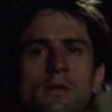

tensor([0], device='cuda:0') tensor([0.8546], device='cuda:0')
Unknown


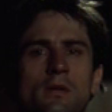

tensor([0], device='cuda:0') tensor([0.8650], device='cuda:0')
Unknown


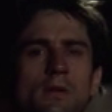

tensor([0], device='cuda:0') tensor([0.8927], device='cuda:0')
Unknown


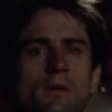

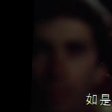

  0%|          | 4/2387 [00:00<01:09, 34.26it/s]

tensor([0, 0], device='cuda:0') tensor([0.8569, 1.0167], device='cuda:0')
['Unknown' 'Unknown']


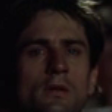

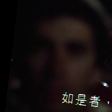

tensor([0, 0], device='cuda:0') tensor([0.8746, 1.0858], device='cuda:0')
['Unknown' 'Unknown']


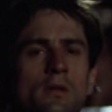

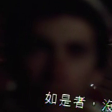

tensor([0, 9], device='cuda:0') tensor([0.8253, 1.0862], device='cuda:0')
['Unknown' 'tt0075314_cluster_11']


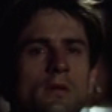

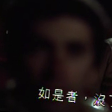

  0%|          | 9/2387 [00:00<00:58, 40.44it/s]

tensor([0, 0], device='cuda:0') tensor([0.8554, 1.1780], device='cuda:0')
['Unknown' 'Unknown']


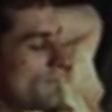

tensor([0], device='cuda:0') tensor([0.9872], device='cuda:0')
Unknown


  1%|          | 17/2387 [00:00<00:42, 55.87it/s]

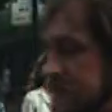

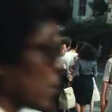

tensor([4, 0], device='cuda:0') tensor([1.0667, 1.0432], device='cuda:0')
['tt0075314_cluster_10' 'Unknown']


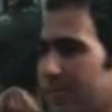

tensor([9], device='cuda:0') tensor([1.0580], device='cuda:0')
tt0075314_cluster_11


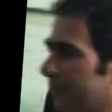

  1%|          | 23/2387 [00:00<00:44, 52.82it/s]

tensor([0], device='cuda:0') tensor([1.0501], device='cuda:0')
Unknown


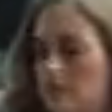

tensor([6], device='cuda:0') tensor([1.0146], device='cuda:0')
tt0075314_cluster_6


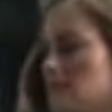

tensor([6], device='cuda:0') tensor([0.8080], device='cuda:0')
tt0075314_cluster_6


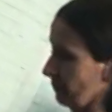

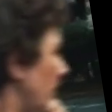

tensor([4, 4], device='cuda:0') tensor([1.0832, 1.1445], device='cuda:0')
['tt0075314_cluster_10' 'tt0075314_cluster_10']


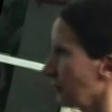

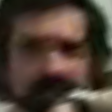

tensor([4, 2], device='cuda:0') tensor([1.1106, 0.9074], device='cuda:0')
['tt0075314_cluster_10' 'tt0075314_cluster_7']


  1%|          | 29/2387 [00:00<00:53, 44.04it/s]

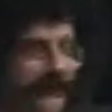

tensor([0], device='cuda:0') tensor([1.1430], device='cuda:0')
Unknown


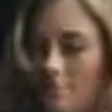

tensor([6], device='cuda:0') tensor([0.8434], device='cuda:0')
tt0075314_cluster_6


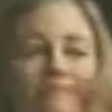

  2%|▏         | 36/2387 [00:00<00:51, 45.94it/s]

tensor([6], device='cuda:0') tensor([0.9762], device='cuda:0')
tt0075314_cluster_6


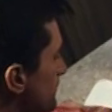

  2%|▏         | 42/2387 [00:00<00:47, 49.53it/s]

tensor([0], device='cuda:0') tensor([1.1108], device='cuda:0')
Unknown


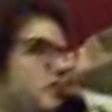

tensor([9], device='cuda:0') tensor([0.7467], device='cuda:0')
tt0075314_cluster_11


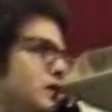

  2%|▏         | 49/2387 [00:01<00:46, 50.64it/s]

tensor([9], device='cuda:0') tensor([0.7810], device='cuda:0')
tt0075314_cluster_11


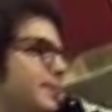

tensor([9], device='cuda:0') tensor([0.7091], device='cuda:0')
tt0075314_cluster_11


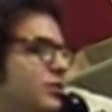

tensor([9], device='cuda:0') tensor([0.7712], device='cuda:0')
tt0075314_cluster_11


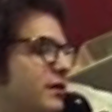

tensor([9], device='cuda:0') tensor([0.6149], device='cuda:0')
tt0075314_cluster_11


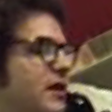

tensor([9], device='cuda:0') tensor([0.6631], device='cuda:0')
tt0075314_cluster_11


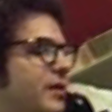

tensor([9], device='cuda:0') tensor([0.6445], device='cuda:0')
tt0075314_cluster_11


  2%|▏         | 55/2387 [00:01<00:51, 45.12it/s]

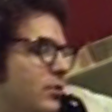

tensor([9], device='cuda:0') tensor([0.6663], device='cuda:0')
tt0075314_cluster_11


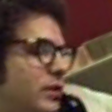

tensor([9], device='cuda:0') tensor([0.6673], device='cuda:0')
tt0075314_cluster_11


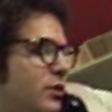

  3%|▎         | 60/2387 [00:01<00:52, 44.22it/s]

tensor([9], device='cuda:0') tensor([0.6355], device='cuda:0')
tt0075314_cluster_11


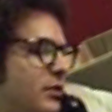

tensor([9], device='cuda:0') tensor([0.6433], device='cuda:0')
tt0075314_cluster_11


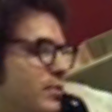

tensor([9], device='cuda:0') tensor([0.7853], device='cuda:0')
tt0075314_cluster_11


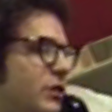

tensor([9], device='cuda:0') tensor([0.6829], device='cuda:0')
tt0075314_cluster_11


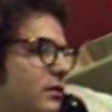

tensor([9], device='cuda:0') tensor([0.6468], device='cuda:0')
tt0075314_cluster_11


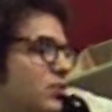

  3%|▎         | 65/2387 [00:01<01:01, 38.06it/s]

tensor([9], device='cuda:0') tensor([0.6489], device='cuda:0')
tt0075314_cluster_11


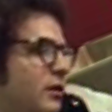

tensor([9], device='cuda:0') tensor([0.6937], device='cuda:0')
tt0075314_cluster_11


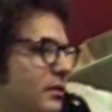

tensor([9], device='cuda:0') tensor([0.6136], device='cuda:0')
tt0075314_cluster_11


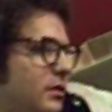

tensor([9], device='cuda:0') tensor([0.6205], device='cuda:0')
tt0075314_cluster_11


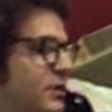

  3%|▎         | 69/2387 [00:01<01:01, 37.44it/s]

tensor([9], device='cuda:0') tensor([0.6691], device='cuda:0')
tt0075314_cluster_11


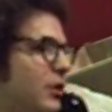

tensor([9], device='cuda:0') tensor([0.6938], device='cuda:0')
tt0075314_cluster_11


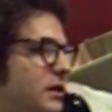

tensor([9], device='cuda:0') tensor([0.6068], device='cuda:0')
tt0075314_cluster_11


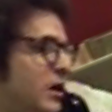

tensor([9], device='cuda:0') tensor([0.7667], device='cuda:0')
tt0075314_cluster_11


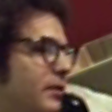

  3%|▎         | 73/2387 [00:01<01:03, 36.56it/s]

tensor([9], device='cuda:0') tensor([0.6562], device='cuda:0')
tt0075314_cluster_11


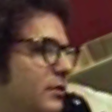

tensor([9], device='cuda:0') tensor([0.6153], device='cuda:0')
tt0075314_cluster_11


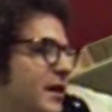

tensor([9], device='cuda:0') tensor([0.6703], device='cuda:0')
tt0075314_cluster_11


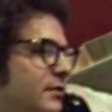

tensor([9], device='cuda:0') tensor([0.6674], device='cuda:0')
tt0075314_cluster_11


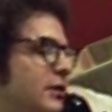

  3%|▎         | 77/2387 [00:01<01:03, 36.50it/s]

tensor([9], device='cuda:0') tensor([0.6402], device='cuda:0')
tt0075314_cluster_11


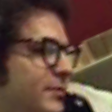

tensor([9], device='cuda:0') tensor([0.6170], device='cuda:0')
tt0075314_cluster_11


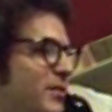

tensor([9], device='cuda:0') tensor([0.6182], device='cuda:0')
tt0075314_cluster_11


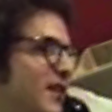

tensor([9], device='cuda:0') tensor([0.6592], device='cuda:0')
tt0075314_cluster_11


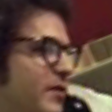

  3%|▎         | 81/2387 [00:01<01:02, 36.93it/s]

tensor([9], device='cuda:0') tensor([0.6844], device='cuda:0')
tt0075314_cluster_11


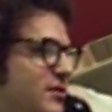

tensor([9], device='cuda:0') tensor([0.6848], device='cuda:0')
tt0075314_cluster_11


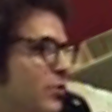

tensor([9], device='cuda:0') tensor([0.6266], device='cuda:0')
tt0075314_cluster_11


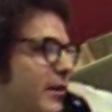

tensor([9], device='cuda:0') tensor([0.7279], device='cuda:0')
tt0075314_cluster_11


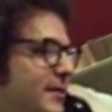

  4%|▎         | 85/2387 [00:02<01:04, 35.86it/s]

tensor([9], device='cuda:0') tensor([0.6088], device='cuda:0')
tt0075314_cluster_11


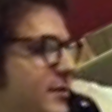

tensor([9], device='cuda:0') tensor([0.6632], device='cuda:0')
tt0075314_cluster_11


  5%|▍         | 108/2387 [00:02<00:39, 58.25it/s]

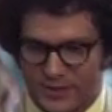

tensor([9], device='cuda:0') tensor([0.7690], device='cuda:0')
tt0075314_cluster_11


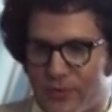

tensor([9], device='cuda:0') tensor([0.6646], device='cuda:0')
tt0075314_cluster_11


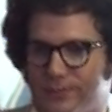

  5%|▍         | 114/2387 [00:02<00:43, 52.76it/s]

tensor([9], device='cuda:0') tensor([0.7369], device='cuda:0')
tt0075314_cluster_11


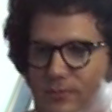

tensor([9], device='cuda:0') tensor([0.7217], device='cuda:0')
tt0075314_cluster_11


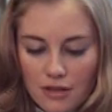

tensor([6], device='cuda:0') tensor([0.6285], device='cuda:0')
tt0075314_cluster_6


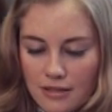

tensor([6], device='cuda:0') tensor([0.6337], device='cuda:0')
tt0075314_cluster_6


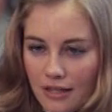

tensor([6], device='cuda:0') tensor([0.5972], device='cuda:0')
tt0075314_cluster_6


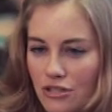

tensor([6], device='cuda:0') tensor([0.6158], device='cuda:0')
tt0075314_cluster_6


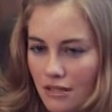

  5%|▌         | 120/2387 [00:02<00:50, 44.63it/s]

tensor([6], device='cuda:0') tensor([0.6195], device='cuda:0')
tt0075314_cluster_6


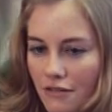

tensor([6], device='cuda:0') tensor([0.5701], device='cuda:0')
tt0075314_cluster_6


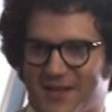

tensor([9], device='cuda:0') tensor([0.7267], device='cuda:0')
tt0075314_cluster_11


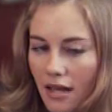

tensor([6], device='cuda:0') tensor([0.7277], device='cuda:0')
tt0075314_cluster_6


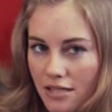

tensor([6], device='cuda:0') tensor([0.7659], device='cuda:0')
tt0075314_cluster_6


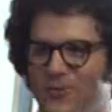

  5%|▌         | 125/2387 [00:02<00:55, 40.44it/s]

tensor([9], device='cuda:0') tensor([0.6909], device='cuda:0')
tt0075314_cluster_11


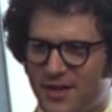

tensor([9], device='cuda:0') tensor([0.7597], device='cuda:0')
tt0075314_cluster_11


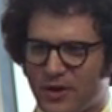

tensor([9], device='cuda:0') tensor([0.7163], device='cuda:0')
tt0075314_cluster_11


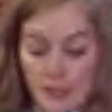

tensor([6], device='cuda:0') tensor([0.9171], device='cuda:0')
tt0075314_cluster_6


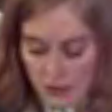

tensor([6], device='cuda:0') tensor([0.8476], device='cuda:0')
tt0075314_cluster_6


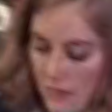

  5%|▌         | 130/2387 [00:02<00:58, 38.79it/s]

tensor([6], device='cuda:0') tensor([0.7948], device='cuda:0')
tt0075314_cluster_6


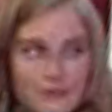

tensor([6], device='cuda:0') tensor([0.9223], device='cuda:0')
tt0075314_cluster_6


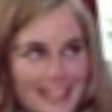

tensor([6], device='cuda:0') tensor([0.9176], device='cuda:0')
tt0075314_cluster_6


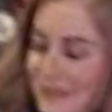

tensor([6], device='cuda:0') tensor([0.8964], device='cuda:0')
tt0075314_cluster_6


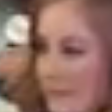

tensor([6], device='cuda:0') tensor([0.9140], device='cuda:0')
tt0075314_cluster_6


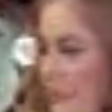

  6%|▌         | 135/2387 [00:03<00:59, 37.57it/s]

tensor([6], device='cuda:0') tensor([1.0258], device='cuda:0')
tt0075314_cluster_6


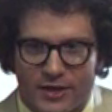

tensor([9], device='cuda:0') tensor([0.7887], device='cuda:0')
tt0075314_cluster_11


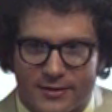

tensor([9], device='cuda:0') tensor([0.8500], device='cuda:0')
tt0075314_cluster_11


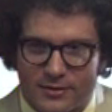

tensor([9], device='cuda:0') tensor([0.7714], device='cuda:0')
tt0075314_cluster_11


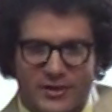

  6%|▌         | 139/2387 [00:03<01:00, 37.32it/s]

tensor([9], device='cuda:0') tensor([0.7874], device='cuda:0')
tt0075314_cluster_11


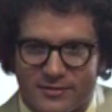

tensor([9], device='cuda:0') tensor([0.7578], device='cuda:0')
tt0075314_cluster_11


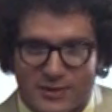

tensor([9], device='cuda:0') tensor([0.8430], device='cuda:0')
tt0075314_cluster_11


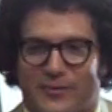

tensor([9], device='cuda:0') tensor([0.7318], device='cuda:0')
tt0075314_cluster_11


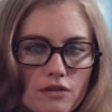

  6%|▌         | 143/2387 [00:03<01:00, 37.20it/s]

tensor([6], device='cuda:0') tensor([0.9063], device='cuda:0')
tt0075314_cluster_6


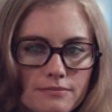

tensor([6], device='cuda:0') tensor([0.8382], device='cuda:0')
tt0075314_cluster_6


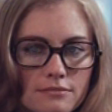

tensor([6], device='cuda:0') tensor([0.8744], device='cuda:0')
tt0075314_cluster_6


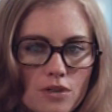

tensor([6], device='cuda:0') tensor([0.9417], device='cuda:0')
tt0075314_cluster_6


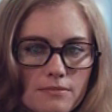

  6%|▌         | 147/2387 [00:03<01:06, 33.53it/s]

tensor([6], device='cuda:0') tensor([0.8625], device='cuda:0')
tt0075314_cluster_6


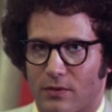

tensor([9], device='cuda:0') tensor([0.7207], device='cuda:0')
tt0075314_cluster_11


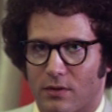

tensor([9], device='cuda:0') tensor([0.7209], device='cuda:0')
tt0075314_cluster_11


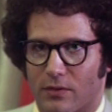

tensor([9], device='cuda:0') tensor([0.7349], device='cuda:0')
tt0075314_cluster_11


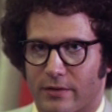

  6%|▋         | 151/2387 [00:03<01:06, 33.70it/s]

tensor([9], device='cuda:0') tensor([0.6933], device='cuda:0')
tt0075314_cluster_11


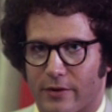

tensor([9], device='cuda:0') tensor([0.6780], device='cuda:0')
tt0075314_cluster_11


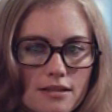

tensor([6], device='cuda:0') tensor([0.9072], device='cuda:0')
tt0075314_cluster_6


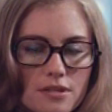

tensor([6], device='cuda:0') tensor([0.9464], device='cuda:0')
tt0075314_cluster_6


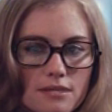

  6%|▋         | 155/2387 [00:03<01:05, 34.01it/s]

tensor([6], device='cuda:0') tensor([0.9721], device='cuda:0')
tt0075314_cluster_6


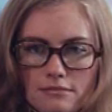

tensor([6], device='cuda:0') 

  7%|▋         | 162/2387 [00:03<00:52, 42.12it/s]

tensor([0.9925], device='cuda:0')
tt0075314_cluster_6


In [25]:
from PIL import Image
import torch
import numpy as np
import torchvision.transforms.functional as F

all_frames = movie_ref.iterate_frames()
i = 0

for frame in tqdm(all_frames):
    faces = frame.iterate_faces()
    
    face_tensors = []
    for f in faces:
        img = f.get_face_image_aligned()

        arr = np.array(img)  # [H, W, C]
        tensor = torch.from_numpy(arr).float()  # [H, W, C]
        face_tensors.append(tensor)
        
        # Convert to PIL Image and display
        pil_image = F.to_pil_image(arr)
        display(pil_image)


    if not face_tensors:
        continue

    faces_batch = torch.stack(face_tensors)  # [N, 112, 112, 3]

    results, score = face_rec.infer(faces_batch, targets)
    person = (names[results.cpu()])
    print(results, score)
    print(person)
    
    i += 1
    if i == 100:
        break